# MCTS

In [84]:
import math
import random
import pickle

# Tree node (Preparation for Monte Carlo Tree Search)
class TreeNode():
    """
    Represents a node in the Monte Carlo Tree Search (MCTS).

    Attributes:
        board: The game board state at this node.
        parent: The parent TreeNode.
        is_terminal: Boolean indicating if the node is a terminal state.
        is_fully_expanded: Boolean indicating if all possible children are expanded.
        visits: Number of times the node has been visited.
        score: Total accumulated score from simulations.
        children: Dictionary mapping action positions to child TreeNodes.
    """
    def __init__(self, board, parent):
        self.board = board # Current board state
        # Terminal node
        if self.board.is_win() or self.board.is_draw():
            self.is_terminal = True
        else:
            self.is_terminal = False

        # Check if the set is fully expanded, initially assume it's fully expanded if terminal
        self.is_fully_expanded = self.is_terminal
        # Reference to parent TreeNode
        self.parent = parent
        # Number of visits
        self.visits = 0
        # Cumulative score from rollouts
        self.score = 0
        # Dictionary of children: position string -> TreeNode
        self.children = {}

# Monte Carlo Tree Search
class MCTS():
    """
    Monte Carlo Tree Search algorithm for decision-making in games.
    """
    # Search for the best move
    def search(self, state):
        """
        Run MCTS simulations from the given initial state and return the best move.
        """
        self.root = TreeNode(state, None) # Create the root of the search tree

        hash_val = state.hash() # Get hash of the board for caching
        if hash_val in score_cache: # Check if score already cached
            self.root.score = score_cache[hash_val] # Load cached score

        for iteration in range(ITER): # Perform ITER simulations

            node = self.select(self.root) # Select a node
            score = self.rollout(node.board) # Simulate the game from that node and score the node
            self.backpropogate(node, score) # Propagate the score back up

        # Store the scores for Q-MCTS algorithms and pick up the best move

        with open('score.pickle', 'wb') as f:
            pickle.dump(score_cache, f)
        with open('visit.pickle', 'wb') as g:
            pickle.dump(child_visit, g)

        return self.get_best_move(self.root, 0) # Return the best move from the root
    
    def select(self, node):
        """
        Select a node to expand using tree policy.
        """
        while not node.is_terminal: # Traverse until terminal state
            # If all children fully expanded
            if node.is_fully_expanded:
                node = self.get_best_move(node, C) # Move to best child using UCB
                if node is None:
                    print("Warning: get_best_move return None!")

            # If not fully expanded
            else:
                new_node = self.expand(node) # Expand the node
                if new_node is None:
                    print("Warning: no valid expansion.")
                return self.expand(node) # Return the newly created node
        return node # Return the terminal node
    
    def expand(self, node):
        """
        Expand a node by adding one unexplored child.
        Returns the newly created child node, or None if fully expanded
        """
        states = node.board.action_space() # Get all legal next states

        # Find unvisited actions
        new_actions = [state for state in states if str(state.position) not in node.children]

        if not new_actions:  # If no new actions to expand
            node.is_fully_expanded = True # Mark node as fully expanded
            return node # No expansion occurred, return the node itself (or return None)

        for state in states: # For each legal state
            # make sure that current state is not present in child nodes
            if str(state.position) not in node.children: # If current states is not already added in child nodes
                new_node = TreeNode(state, node) # Create a new child node
                node.children[str(state.position)] = new_node # add the child node

                # Check if (parent) fully expanded
                if len(states) == len(node.children):
                    node.is_fully_expanded = True

                return new_node # Return the new childen
    
    def rollout(self, board):
        """
        Simulate the game randomly from the given board state until the end.

        Args:
            board: The initial game board state.

        Returns:
            Reward for the terminal game state (1 for win, -1 for loss, 0 for draw).
        """
        while not board.is_win() and not board.is_draw():
            board = random.choice(board.training_action())
            print(board)
        # print("Win State:", board.is_win())
        # print("Draw State:", board.is_draw())

        if board.is_win():
            if board.player_2 == -1:
                # print("Reward: 1")
                return 1
            elif board.player_2 == 1:
                # print("Reward: -1")
                return -1
        else:
            # print("Reward: 0 ")
            return 0

    def backpropogate(self, node, score):
        """
        Backpropagate the simulation result up the tree.

        Args:
            node: The node to start backpropagation from.
            score: The result of the rollout to propagate.
        """
        while node is not None:
            node.visits += 1
            node.score += score
            node = node.parent
    
    def get_best_move(self, node, eps):
        """
        Select the best child node using the Upper Confidence Bound (UCB1) formula.

        Args:
            node: The current TreeNode whose children to evaluate.
            eps: The exploration parameter in the UCB formula.

        Returns:
            The best TreeNode to move to next.
        """
        best_score = float("-inf")  # Initialize best score
        best_moves = []  # List of equally best moves

        for child_node in node.children.values():  # Check all children
            current_player = child_node.board.player_2  # Determine current player

            hash_val = child_node.board.hash()  # Hash of board for caching

            if child_node.visits != 0:  # Only consider visited nodes
                if hash_val not in score_cache:  # First time: store values
                    score_cache[hash_val] = child_node.score
                    child_visit[hash_val] = child_node.visits
                else:  # Update existing values if visit count changed
                    if child_visit[hash_val] != child_node.visits:
                        # Update score with new average
                        score_cache[hash_val] = (
                            (score_cache[hash_val] + 
                            child_node.score / child_node.visits) / 
                            child_node.visits
                        )
                        child_visit[hash_val] = child_node.visits

            # Compute UCB1 score for child node
            move_score = (
                current_player * child_node.score / (child_node.visits + 1e-14) +
                eps * math.sqrt(math.log(node.visits) / (child_node.visits + 1e-13))
            )

            if move_score > best_score:  # Found better score
                best_score = move_score
                best_moves = [child_node]  # Reset best moves
            elif move_score == best_score:  # Tie case
                best_moves.append(child_node)

        return random.choice(best_moves)  # Break ties randomly

In [ ]:
from copy import deepcopy
import pickle

BOARD_ROW = 12
BOARD_COL = 12
WIN_COUNT = 4
ITER = 10
training_iter = 2000
C = 2 # Exploration constant

class Board():
    """
    A class to represent a probabilistic Super Tic-Tac-Toe board.
    Handles game logic including move attempts, state transitions,
    win/draw conditions, and board representation.
    """
    def __init__(self, board=None):
        """
        Initializes a new board or copies from an existing board.

        Args:
            board (Board, optional): If provided, creates a deep copy.
        """
        self.player_1 = 1 
        self.player_2 = -1 
        self.empty_position = 0 # Empty cell representation

        # Positions
        self.position = {} # Board state as a dictionary

        # Reset
        self.reset_board() # Initialize board to empty state
        self.new_row = 0 # Row index for current move
        self.new_col = 0 # Col index for current move

        # Hash Value
        self.hash_val = 0 # Cached baord hash

        # Previous board state
        if board is not None: 
            # Deep copy from another board
            self.__dict__ = deepcopy(board.__dict__)
    
    def hash(self):
        """
        Computes a unique hash value for the board state.

        Returns:
            int: Integer hash based on cell values.
        """
        self.hash_val = 0
        for row in range(BOARD_ROW):
            for col in range(BOARD_COL):
                # Combine cell values into a single hash
                self.hash_val = self.hash_val * 6 + self.position[row, col] + 1
            return self.hash_val

    def reset_board(self):
        """
        Resets the board to an empty state.
        """
        for row in range(BOARD_ROW):
            for col in range(BOARD_COL):
                self.position[row, col] = self.empty_position # Clear each cell
        self.hash_val = 0 # Reset cached hash
    
    def move(self, row, col):
        """
        Applies a probabilistic move: 50% chance of placing at (row, col),
        otherwise attempts a nearby random move.

        Args:
            row (int): Target row.
            col (int): Target column.

        Returns:
            Board: New board state after move.
        """
        if random.random() <= 0.5: 
            return self.apply_move(row, col) # Try nomal move
        else:
            return self.random_move(row, col) # Try random nearby move
    
    def apply_move(self, row, col):
        """
        Applies a move at (row, col) if it's empty. Switches player turn.

        Args:
            row (int): Row index.
            col (int): Column index.

        Returns:
            Board: New state with updated move, or skipped if cell occupied.
        """
        if self.position.get((row, col), None) == self.empty_position:
            board = Board(self)  # inherit from current position
            board.position[row, col] = self.player_1  # place current player's move
            (board.player_1, board.player_2) = (board.player_2, board.player_1) # Swap players
            return board
        else:
            # If cell taken, skip turn (still swap players)
            board = Board(self)
            (board.player_1, board.player_2) = (board.player_2, board.player_1)
            return board  # Move forfeited if the spot is not empty
    
    def is_valid_position(self, row, col):
        """
        Checks if a cell is within the valid cross-shaped board layout.

        Args:
            row (int): Row index.
            col (int): Column index.

        Returns:
            bool: True if cell is playable, False otherwise.
        """
        # Cross layout has vertical and horizontal arms
        vertical_part = (0 <= row <= 11) and (4 <= col < 8)
        horizontal_part = (4 <= row < 8) and (0 <= col <= 11)
        return vertical_part or horizontal_part

    def random_move(self, row, col):
        """
        Attempts a move in a nearby adjacent valid empty cell.

        Args:
            row (int): Original move row.
            col (int): Original move column.

        Returns:
            Board: New board state after random adjacent move.
        """
        # All 8 adjacent directions
        adjacent_positions = [
            (row-1, col-1), (row-1, col), (row-1, col+1),
            (row, col-1), (row, col+1),
            (row+1, col-1), (row+1, col), (row+1, col+1)
        ]
        # Filter valid board coordinates
        valid_positions = [(r, c) for (r, c) in adjacent_positions if 0 <= r < BOARD_ROW and 0 <= c < BOARD_COL]
        # Check board layout and emptiness
        valid_positions = [(r, c) for (r, c) in valid_positions if self.is_valid_position(r, c)]
        valid_positions = [(r, c) for (r, c) in valid_positions if self.position.get((r, c), None) == self.empty_position]

        if valid_positions:
            chosen_row, chosen_col = random.choice(valid_positions)
            return self.apply_move(chosen_row, chosen_col)
        else:
            # No valid adjacent cells, skip turn
            board = Board(self)
            board.player_1, board.player_2 = board.player_2, board.player_1
            return board # Move forfeited if all random choices are invalid

    def is_draw(self):
        """
        Checks if the board is in a draw state (no empty cells).

        Returns:
            bool: True if draw, False otherwise.
        """
        for row, col in self.position:
            if self.position[row, col] == self.empty_position:
                return False
        return True

    def is_win(self):
        """
        Checks if the current board state is a win for the previous player.

        Returns:
            bool: True if last move caused a win, False otherwise.
        """
        target = 4
        diagonal_target = 5
        
        # Check vertical part (12x4 grid at columns 6-9)
        for row in range(13 - target):  # 0 to 8 (12-4=8)
            for col in range(4, 8):
                # Only check if the vertical part is fully within valid positions
                if all(self.is_valid_position(row + k, col) for k in range(target)):
                    if all(self.position[row + k, col] == self.player_2 for k in range(target)):
                        return True
        
        # Check horizontal part (4x12 grid at rows 6-9)
        for row in range(4, 8):
            for col in range(13 - target):  # 0 to 8 (12-4=8)
                # Only check if the horizontal part is fully within valid positions
                if all(self.is_valid_position(row, col + k) for k in range(target)):
                    if all(self.position[row, col + k] == self.player_2 for k in range(target)):
                        return True

        # Check diagonals (top-left to bottom-right)
        for row in range(12 - diagonal_target + 1):
            for col in range(12 - diagonal_target + 1):
                # Only check if the diagonal is fully within valid positions
                if all(self.is_valid_position(row + k, col + k) for k in range(diagonal_target)):
                    if all(self.position[row + k, col + k] == self.player_2 for k in range(diagonal_target)):
                        return True

        # Check diagonals (top-right to bottom-left)
        for row in range(12 - diagonal_target + 1):
            for col in range(diagonal_target - 1, 12):
                # Only check if the diagonal is fully within valid positions
                if all(self.is_valid_position(row + k, col - k) for k in range(diagonal_target)):
                    if all(self.position[row + k, col - k] == self.player_2 for k in range(diagonal_target)):
                        return True
            
        return False
    

    def action_space(self):
        """
        Generates all valid next board states from available empty cells.

        Returns:
            list: All valid next Board instances.
        """
        actions = []

        for row in range(BOARD_ROW):
            for col in range(BOARD_COL):
                # make sure that current square is empty
                self.new_row = row
                self.new_col = col
                if self.position[row, col] == self.empty_position:
                    new_board = self.apply_move(row, col)
                    if new_board:
                        actions.append(new_board)

        return [action for action in actions if action is not None]

    def training_action(self):
        """
        Generates all possible board states using `move()` logic (with randomness),
        for training purposes.

        Returns:
            list: All next possible states under probabilistic moves.
        """
        actions = []

        for row in range(BOARD_ROW):
            for col in range(BOARD_COL):
                # make sure that current square is empty
                actions.append(self.move(row, col))

        return [action for action in actions if action is not None]

    # Human VS AI(O-MCTS)
    def game_loop(self):

        print('\n  Super Tic Tac Toc')
        print('  Enter the move like: 1,5 ([row], [col]) (The first index is 1 and please remember to use English comma ",".)')
        print("  After a player chooses an empty square, there is only ½ chance that his nought or cross is placed at the chosen square.")
        print("  If the player's choice is not accepted, the player's move is selected randomly with probability 1/16 by the computer from the 8 random squares adjacent to the chosen one, with the boundaries ignored.")
        print("  If the random choice is occupied or outside of the board, the player's move is forfeited.")
        print("  For example, if the chosen square is at the corner, with probability 5/16 the randomly selected square is outside of the board.")
        print('  Type "quit" to quit the game.')

        print(self)

        # AI agent
        # mcts = MCTS()

        while True:

            user_input = input('> ')
            if user_input == 'quit':
                break

            if user_input == '':
                continue

            try:

                row = int(user_input.split(',')[0]) - 1
                col = int(user_input.split(',')[1]) - 1

                self = self.move(row, col)
                print(self)

                if self.is_win():
                    if self.player_2 == -1:
                        label = 'o'
                    else:
                        label = 'x'
                    print('Player "%s"' % label, "has won the game! Congratulation!")
                    break
                elif self.is_draw():
                    print("Game is drawn.")
                    break

                # AI turn
                #try:
                board = Board(self)
                best_move = self.search(board)
                next_row = list(dict(set(best_move.board.position.items()) - set(board.position.items())).keys())[0][0]
                next_col = list(dict(set(best_move.board.position.items()) - set(board.position.items())).keys())[0][1]
                print("AI wants to choose: (%s, %s)" % (next_row+1, next_col+1))
                self = self.move(next_row, next_col)

                #except Exception as e:
                #print(e)

                print(self)

                # Check win or draw
                if self.is_win():
                    if self.player_2 == -1:
                        label = 'o'
                    else:
                        label = 'x'
                    print('Player "%s"' % label, "has won the game! Congratulation!")
                    break
                elif self.is_draw():
                    print("Game is drawn.")
                    break

            except:
                print("Invalid input!")
                continue
    
    # Human VS AI (Online-Offline MCTS)
    def game_book(self):
        print('\n  Super Tic Tac Toc')
        print('  Enter the move like: 1,5 ([row], [col]) (The first index is 1 and please remember to use English comma ",".)')
        print("  After a player chooses an empty square, there is only ½ chance that his nought or cross is placed at the chosen square.")
        print("  If the player's choice is not accepted, the player's move is selected randomly with probability 1/16 by the computer from the 8 random squares adjacent to the chosen one, with the boundaries ignored.")
        print("  If the random choice is occupied or outside of the board, the player's move is forfeited.")
        print("  For example, if the chosen square is at the corner, with probability 5/16 the randomly selected square is outside of the board.")
        print('  Type "quit" to quit the game.')

        print(self)

        # AI agent


        while True:

            user_input = input('> ')
            if user_input == 'quit':
                break

            if user_input == '':
                continue

            try:

                row = int(user_input.split(',')[0]) - 1
                col = int(user_input.split(',')[1]) - 1

                self = self.move(row, col)
                print(self)

                if self.is_win():
                    if self.player_2 == -1:
                        label = 'o'
                    else:
                        label = 'x'
                    print('Player "%s"' % label, "has won the game! Congratulation!")
                    break
                elif self.is_draw():
                    print("Game is drawn.")
                    break

                # AI turn
                #try:
                next_move = self.action_space()
                best_moves = []
                best_score = float("-inf")

                for move in next_move:
                    if move.hash() in score_cache:
                        move_score = score_cache[move.hash()]
                        if move_score > best_score:
                            best_score = move_score
                            best_moves = [move]

                        elif move_score == best_score:
                            best_moves.append(move)

                if len(best_moves) > 0:
                    print("Strategy is found")
                    board = Board(self)
                    best_move = random.choice(best_moves)
                    next_row = list(dict(set(best_move.position.items()) - set(board.position.items())).keys())[0][0]
                    next_col = list(dict(set(best_move.position.items()) - set(board.position.items())).keys())[0][1]

                else:
                    print("Thinking...")
                    board = Board(self)
                    best_move = mcts.search(board)
                    next_row = list(dict(set(best_move.board.position.items()) - set(board.position.items())).keys())[0][0]
                    next_col = list(dict(set(best_move.board.position.items()) - set(board.position.items())).keys())[0][1]

                print("AI wants to choose: (%s, %s)" % (next_row+1, next_col+1))
                self = self.move(next_row, next_col)

                print(self)


                # Check win or draw
                if self.is_win():
                    if self.player_2 == -1:
                        label = 'o'
                    else:
                        label = 'x'
                    print('Player "%s"' % label, "has won the game! Congratulation!")
                    break
                elif self.is_draw():
                    print("Game is drawn.")
                    break

            except Exception as e:
                print("Invalid input!")
                print(e)
                continue
    
    # Print the board
    def __str__(self):
        board_str = ''
        for row in range(BOARD_ROW):
            for col in range(BOARD_COL):
                if self.is_valid_position(row, col):
                    if self.position[row, col] == 1:
                        symbol = 'x'
                    elif self.position[row, col] == -1:
                        symbol = 'o'
                    else:
                        symbol = '.'
                    board_str += " %s" % symbol
                else:
                    board_str += "  " # Two spaces for alignment
            board_str += '\n'

        if self.player_1 == 1:
            board_str = '\n ---------------- \n You to move: \n----------------\n\n' + board_str

        elif self.player_1 == -1:
            board_str = '\n ---------------- \n AI to move: \n----------------\n\n' + board_str

        return board_str

    # Training the strategies similar as Q-learning
    def training(self, num):
        for i in range(num):
            print(f"Training iteration: {i+1}")
            while not self.is_win() and not self.is_draw():
                board = Board(self)
                next_move = self.action_space()
                move = random.choice(next_move)
                next_row = list(dict(set(move.position.items()) - set(board.position.items())).keys())[0][0]
                next_col = list(dict(set(move.position.items()) - set(board.position.items())).keys())[0][1]
                self = self.move(next_row, next_col)
                board = Board(self)
                if self.is_win() or self.is_draw():
                    break
                best_move = mcts.search(board)
                next_row = list(dict(set(best_move.board.position.items()) - set(board.position.items())).keys())[0][0]
                next_col = list(dict(set(best_move.board.position.items()) - set(board.position.items())).keys())[0][1]
                self = self.move(next_row, next_col)
            self.reset_board()
    
    def print_train(self):
        win_record = []
        for i in range(num):
            print(f"Training iteration: {i+1}")
            while not self.is_win() and not self.is_draw():
                board = Board(self)
                next_move = self.action_space()
                move = random.choice(next_move)
                next_row = list(dict(set(move.position.items()) - set(board.position.items())).keys())[0][0]
                next_col = list(dict(set(move.position.items()) - set(board.position.items())).keys())[0][1]
                self = self.move(next_row, next_col)
                board = Board(self)
                if self.is_win() or self.is_draw():
                    break
                best_move = mcts.search(board)
                next_row = list(dict(set(best_move.board.position.items()) - set(board.position.items())).keys())[0][0]
                next_col = list(dict(set(best_move.board.position.items()) - set(board.position.items())).keys())[0][1]
                self = self.move(next_row, next_col)
            if self.is_win():
                if self.player_2 == -1:
                    win_record.append(1)
                else:
                    win_record.append(-1)
            else:
                win_record.append(0)
            self.reset_board()

    # AI(Random) VS AI(Q-MCTS)
    def print_book(self):
        win_record = []
        for i in range(training_iter):
            label = 0
            print(f"Training iteration: {i+1}")
            while not self.is_win() and not self.is_draw():
                #input('')
                #print(self)
                board = Board(self)
                next_move = self.action_space()
                move = random.choice(next_move)
                next_row = list(dict(set(move.position.items()) - set(board.position.items())).keys())[0][0]
                next_col = list(dict(set(move.position.items()) - set(board.position.items())).keys())[0][1]
                self = self.move(next_row, next_col)

                if self.is_win():
                    if self.player_2 == -1:
                        win_record.append(1)
                    else:
                        win_record.append(-1)
                    self.reset_board()
                    label = 1
                    break
                elif self.is_draw():
                    win_record.append(0)
                    self.reset_board()
                    label = 1
                    break

                next_move = self.action_space()
                best_moves = []
                best_score = float("-inf")

                for move in next_move:
                    if move.hash() in score_cache:
                        move_score = score_cache[move.hash()]
                        if move_score > best_score:
                            best_score = move_score
                            best_moves = [move]

                        elif move_score == best_score:
                            best_moves.append(move)
                
                if len(best_moves) > 0:
                    board = Board(self)
                    best_move = random.choice(best_moves)
                    next_row = list(dict(set(best_move.position.items()) - set(board.position.items())).keys())[0][0]
                    next_col = list(dict(set(best_move.position.items()) - set(board.position.items())).keys())[0][1]

                else:
                    board = Board(self)
                    next_move = self.action_space()
                    move = random.choice(next_move)
                    next_row = list(dict(set(move.position.items()) - set(board.position.items())).keys())[0][0]
                    next_col = list(dict(set(move.position.items()) - set(board.position.items())).keys())[0][1]

                self = self.move(next_row, next_col)
            
            if label == 0:
                if self.is_win():
                    print("Win:", i)
                    if self.player_2 == -1:
                        win_record.append(1)
                    else:
                        win_record.append(-1)
                else:
                    print("Draw:", i)
                    win_record.append(0)

            self.reset_board()
        return win_record
    
if __name__ == '__main__':
    with open('score.pickle', 'rb') as f:
        score_cache = pickle.load(f)
    with open('visit.pickle', 'rb') as g:
        child_visit = pickle.load(g)
    
    board = Board()
    mcts = MCTS()
    win_record = board.print_book()
    # mcts.rollout(board)

In [8]:
print(board)


 ---------------- 
 You to move: 
----------------

         . . . .        
         . . . .        
         . . . .        
         . . . .        
 . . . . . . . . . . . .
 . . . . . . . . . . . .
 . . . . . . . . . . . .
 . . . . . . . . . . . .
         . . . .        
         . . . .        
         . . . .        
         . . . .        



# Testing Rules

In [34]:
board = Board()
board.position[(0,4)] = -1
board.position[(1,5)] = -1
board.position[(2,6)] = -1
board.position[(3,7)] = -1
board.position[(4,8)] = -1

print(board)
board.is_win()



 ---------------- 
 You to move: 
----------------

         o . . .        
         . o . .        
         . . o .        
         . . . o        
 . . . . . . . . o . . .
 . . . . . . . . . . . .
 . . . . . . . . . . . .
 . . . . . . . . . . . .
         . . . .        
         . . . .        
         . . . .        
         . . . .        



In [18]:
board2 = Board()
board2.position[(0,4)] = -1
board2.position[(1,5)] = -1
board2.position[(5,6)] = -1
board2.position[(3,7)] = -1
board2.position[(4,8)] = -1
print(board2)
board2.is_win()


 ---------------- 
 You to move: 
----------------

         o . . .        
         . o . .        
         . . . .        
         . . . o        
 . . . . . . . . o . . .
 . . . . . . o . . . . .
 . . . . . . . . . . . .
 . . . . . . . . . . . .
         . . . .        
         . . . .        
         . . . .        
         . . . .        



False

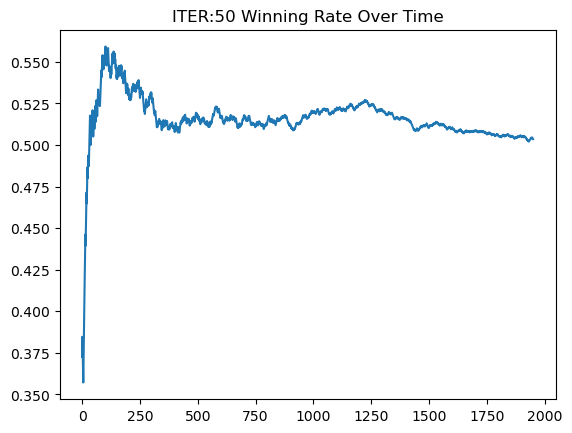

In [46]:
winrate = [1 if win_record[i] == 1 else 0 for i in range(len(win_record))]
plot_win = []
plot_draw = []
total_win = sum(winrate[1:50])
for i in range(50,len(winrate)):
  total_win += winrate[i]
  plot_win.append(total_win / (i+1))
# Winning rate when ITER = 50
import matplotlib.pyplot as plt
plt.plot(plot_win)
plt.title("ITER:50 Winning Rate Over Time")  # Add this line for the title
plt.show()

# Check stochastic transition property & Human VS AI demo under online-offline MCTS
##### Show rollout until the end to get the reward after human place the first nought.


In [ ]:
if __name__ == '__main__':
    board = Board()
    mcts = MCTS()
    board.game_book()


  Super Tic Tac Toc
  Enter the move like: 1,4 ([row], [col]) (The first index is 1 and please remember to use English comma ",".)
  After a player chooses an empty square, there is only ½ chance that his nought or cross is placed at the chosen square.
  If the player's choice is not accepted, the player's move is selected randomly with probability 1/16 by the computer from the 8 random squares adjacent to the chosen one, with the boundaries ignored.
  If the random choice is occupied or outside of the board, the player's move is forfeited.
  For example, if the chosen square is at the corner, with probability 5/16 the randomly selected square is outside of the board.
  Type "quit" to quit the game.

 ---------------- 
 You to move: 
----------------

         . . . .        
         . . . .        
         . . . .        
         . . . .        
 . . . . . . . . . . . .
 . . . . . . . . . . . .
 . . . . . . . . . . . .
 . . . . . . . . . . . .
         . . . .        
         . .

# Unit Test


In [105]:
# Test board
import unittest

class TestDiagonalWins(unittest.TestCase):
    def test_diagonal_top_right_to_bottom_left(self):
      # Test each possible starting point for the diagonal win on a cross-shaped board
      for start_row in range(4):  # Allows space for 5 markers diagonally
        for start_col in range(7,8):  # Ensures the diagonal can fit in the board
          board = Board()
          board.current_player = board.player_2  # Assuming -1 is the player to check
          # Set the pieces along the diagonal
          for i in range(5):  # Place 5 pieces to form a win
            row = start_row + i
            col = start_col - i
            board.position[row, col] = board.current_player
          self.assertTrue(board.is_win(), f"Failed at starting position ({start_row}, {start_col})")

class TestDiagonalWins2(unittest.TestCase):
  def test_diagonal_top_left_to_bottom_right(self):
      # Test diagonal win from top-left to bottom-right
      for start_row in range(4):  # Only the first three rows can start a diagonal of 4
        for start_col in range(4,5):  # Only the first three columns can start a diagonal of 4
          board = Board()
          board.current_player = board.player_2  # Assuming -1 is the player to check
          for i in range(5):
            board.position[start_row + i, start_col + i] = board.current_player
          self.assertTrue(board.is_win(), f"Should detect diagonal win starting at {start_row},{start_col}")

class TesthorizontalWins(unittest.TestCase):
  def test_horizontal_wins(self):
    # Test horizontal win conditions for each row
    for row in range(4,8):
      board = Board()
      board.current_player = board.player_2  # Assuming -1 is the player to check
      for col in range(4):  # Only need the first four columns to test horizontal win
        board.position[row, col] = board.current_player
      self.assertTrue(board.is_win(), f"Should detect horizontal win at row {row}")

class TestverticalWins(unittest.TestCase):
  def test_vertical_wins(self):
    # Test vertical win conditions for each column
    for col in range(4,8):
      board = Board()
      board.current_player = board.player_2  # Assuming -1 is the player to check
      for row in range(4):  # Only need the first four rows to test vertical win
        board.position[row, col] = board.current_player
      self.assertTrue(board.is_win(), f"Should detect vertical win at column {col}")

# Running the tests
def run_all_tests():
  loader = unittest.TestLoader()
  suite = unittest.TestSuite()
  # Add all test classes
  suite.addTests(loader.loadTestsFromTestCase(TestDiagonalWins))
  suite.addTests(loader.loadTestsFromTestCase(TestDiagonalWins2))
  suite.addTests(loader.loadTestsFromTestCase(TesthorizontalWins))
  suite.addTests(loader.loadTestsFromTestCase(TestverticalWins))
  # Run all the tests
  runner = unittest.TextTestRunner()
  runner.run(suite)

# Call the function to run all tests
run_all_tests()

....
----------------------------------------------------------------------
Ran 4 tests in 0.010s

OK


# Check Rollout of MCTS

In [ ]:
# Rollout till the end to get the reward after human place the first nought.
board = Board()
mcts = MCTS()
mcts.rollout(board) # Please remove '#' before print in the function of rollout to see the testing outputs.